<a href="https://colab.research.google.com/github/cemreefe/cmpe493-project/blob/main/493_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install xmltodict

import os
import tarfile
import pandas as pd
import xmltodict
import json
import io   
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def read_file(path):
  with open(path, 'r') as f:
    return f.read()

In [4]:
if not os.path.exists('drive/MyDrive/CMPE/CMPE493'):
  os.makedirs('drive/MyDrive/CMPE/CMPE493')

In [5]:
if not os.path.exists('drive/MyDrive/CMPE/CMPE493/topics-rnd5.xml'):
  !curl https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml --output drive/MyDrive/CMPE/CMPE493/topics-rnd5.xml

if not os.path.exists('drive/MyDrive/CMPE/CMPE493/qrels-covid_d5_j0.5-5.txt'):
  !curl https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt --output drive/MyDrive/CMPE/CMPE493/qrels-covid_d5_j0.5-5.txt

if not os.path.exists('drive/MyDrive/CMPE/CMPE493/cord-19_2020-07-16.tar.gz'):
  !curl https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases/cord-19_2020-07-16.tar.gz --output drive/MyDrive/CMPE/CMPE493/cord-19_2020-07-16.tar.gz

In [6]:
if not os.path.exists('2020-07-16'):
  tar = tarfile.open('drive/MyDrive/CMPE/CMPE493/cord-19_2020-07-16.tar.gz', "r:gz")
  tar.extractall()
  tar.close()

In [7]:
df_metadata = pd.read_csv('2020-07-16/metadata.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
del df_metadata['sha'], df_metadata['source_x'], df_metadata['doi'], df_metadata['pmcid'], df_metadata['pubmed_id'], df_metadata['license'], df_metadata['publish_time'], df_metadata['authors'], df_metadata['journal'], df_metadata['mag_id'], df_metadata['who_covidence_id'], df_metadata['arxiv_id'], df_metadata['pdf_json_files'], df_metadata['pmc_json_files'], df_metadata['url'], df_metadata['s2_id']

In [9]:
df_metadata[df_metadata['cord_uid'] == 'ug7v899j']

,cord_uid,title,abstract
0,ug7v899j,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...


In [10]:
df_metadata.drop_duplicates(subset='cord_uid', keep='first', inplace=True)

In [11]:
df_metadata

,cord_uid,title,abstract
0,ug7v899j,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...
1,02tnwd4m,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...
2,ejv2xln0,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...
3,2b73a28n,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...
4,9785vg6d,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...
...,...,...,...
192504,z4ro6lmh,Rapid radiological improvement of COVID-19 pne...,NaN
192505,hi8k8wvb,SARS E protein in phospholipid bilayers: an an...,Abstract We report on an anomalous X-ray refle...
192506,ma3ndg41,Italian Society of Interventional Cardiology (...,COVID‐19 pandemic raised the issue to guarante...
192507,wh10285j,"Nimble, Together: A Training Program's Respons...",NaN


In [12]:
topic_relevances = 'topic iter document_id judgement\n' + read_file('drive/MyDrive/CMPE/CMPE493/qrels-covid_d5_j0.5-5.txt')

df_relevances = pd.read_csv(  io.StringIO(topic_relevances)  , sep=" ")
del df_relevances['iter']

df_relevances

,topic,document_id,judgement
0,1,005b2j4b,2
1,1,00fmeepz,1
2,1,010vptx3,2
3,1,0194oljo,1
4,1,021q9884,1
...,...,...,...
69313,50,zvop8bxh,2
69314,50,zwf26o63,1
69315,50,zwsvlnwe,0
69316,50,zxr01yln,1


In [13]:
topics_obj = xmltodict.parse(read_file('drive/MyDrive/CMPE/CMPE493/topics-rnd5.xml'))
topics     = json.loads(json.dumps(topics_obj))

topics_dict = {}
for topic in topics['topics']['topic']:
  # a topic has the following fields:
  #  * @number
  #  * narrative
  #  * query
  #  * question
  topics_dict[topic['@number']] = topic['query'] + ' ' + topic['question'] + ' ' + topic['narrative']

In [14]:
len(topics_dict)

50

# Data so far

* `topics_dict` 
      has `topic-id` for keys, and topic description for values
* `df_relevances` 
      has the following three columns:
      topic	document-id	judgement
* `df_metadata`
      holds information about the documents
      has the following three columns (others are deleted):
      cord_uid	title	abstract


In [15]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
#stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
import numpy as np

docs = np.array(df_metadata)
contents = {}

for doc in docs:
  contents[doc[0]] = f'{doc[1]} {doc[2]}'

In [17]:
import string
import re
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
sw = stopwords.words('english')

def preprocess(s):
  s = s.casefold()
  s = s.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
  s = re.sub("\d+", "", s) #Delete numbers
  s = ' '.join([porter_stemmer.stem(word) for word in s.split() if word not in sw or word != 'nan'])
  return s

In [24]:
'''
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(preprocessor=preprocess)
vectors = vectorizer.fit_transform(list(contents.values()) + list(topics_dict.values()))
'''

In [25]:
'''
doc_vectors = vectors[:-50]
topic_vectors = vectors[-50:]
'''

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

if not os.path.exists("drive/MyDrive/CMPE/CMPE493/doc_vectors.pickle"):
  doc_vectorizer = TfidfVectorizer(preprocessor=preprocess)
  doc_vectors = doc_vectorizer.fit_transform(list(contents.values()))
else:
  doc_vectors = pickle.load(open("drive/MyDrive/CMPE/CMPE493/doc_vectors.pickle", "rb"))

print(len(doc_vectorizer.vocabulary_))


145403


In [40]:
if not os.path.exists("drive/MyDrive/CMPE/CMPE493/topic_vectors.pickle"):
  topic_vectorizer = TfidfVectorizer(preprocessor=preprocess,vocabulary=doc_vectorizer.vocabulary_)
  topic_vectors = topic_vectorizer.fit_transform(list(topics_dict.values()))
else:
  topic_vectors = pickle.load(open("drive/MyDrive/CMPE/CMPE493/topic_vectors.pickle", "rb"))


In [41]:
doc_vectors.shape

(191175, 145403)

In [25]:
doc_vectors_dict = {
    docs[i][0] : doc_vectors[i]
    for i in range(0,len(docs))
}

In [26]:
topic_vectors_dict = {
    key : topic_vectors[i]
    for i, key in enumerate(topics_dict.keys())
}

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
#Takes random doc_id and prints most relevant topic
ex_document = df_metadata.sample().cord_uid.to_string().split()[1]
similarity = cosine_similarity(doc_vectors_dict[ex_document],topic_vectors).flatten()

print(ex_document)
print(similarity)
print(np.max(similarity))
print(np.argmax(similarity))
print(contents[ex_document])
print(topics_dict[str(np.argmax(similarity) + 1)])

eisccywr
[0.02952238 0.07045869 0.02011262 0.01654735 0.04492067 0.02982597
 0.03066501 0.04740968 0.03222383 0.02292933 0.02149207 0.05301359
 0.03220635 0.03270433 0.02026007 0.03206118 0.01264713 0.02124151
 0.02382768 0.02533525 0.06596861 0.03486039 0.01905762 0.01905762
 0.03529942 0.04510459 0.02689005 0.03380872 0.04902482 0.01722346
 0.03947991 0.01688038 0.05171405 0.03105881 0.00835648 0.05775903
 0.08929254 0.06147197 0.03585059 0.05124327 0.05886667 0.05730822
 0.03266009 0.04507639 0.02675539 0.05184821 0.0504539  0.0665852
 0.03431802 0.02293569]
0.08929253509643427
36
WRKY genes family study reveals tissue-specific and stress-responsive TFs in wild potato species Wild potatoes, as dynamic resource adapted to various environmental conditions, represent a powerful and informative reservoir of genes useful for breeding efforts. WRKY transcription factors (TFs) are encoded by one of the largest families in plants and are involved in several biological processes such as grow

In [28]:
df_relevances['cosine_similarity'] = df_relevances.apply(
    lambda r: cosine_similarity(topic_vectors_dict[str(r.topic)], doc_vectors_dict[r.document_id]).flatten()[0],
    axis=1
)

In [29]:
df_relevances

,topic,document_id,judgement,cosine_similarity
0,1,005b2j4b,2,0.107904
1,1,00fmeepz,1,0.240595
2,1,010vptx3,2,0.157505
3,1,0194oljo,1,0.248728
4,1,021q9884,1,0.147333
...,...,...,...,...
69313,50,zvop8bxh,2,0.055619
69314,50,zwf26o63,1,0.251637
69315,50,zwsvlnwe,0,0.294331
69316,50,zxr01yln,1,0.083022


In [30]:
stuff = np.abs(np.array(df_relevances.judgement) - np.array(df_relevances.cosine_similarity)*2)

In [31]:
np.mean(stuff)

0.5994017992112892

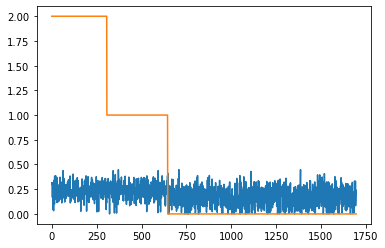

In [42]:
similarities = np.array(df_relevances[df_relevances['topic'] == 5].sort_values(by=["judgement"],ascending=False).cosine_similarity)

import matplotlib.pyplot as plt
plt.plot(similarities)
plt.plot(np.array(df_relevances[df_relevances['topic'] == 5].sort_values(by=["judgement"],ascending=False).judgement))

In [37]:
import pickle
pickle.dump(doc_vectors, open("drive/MyDrive/CMPE/CMPE493/doc_vectors.pickle", "wb"))
pickle.dump(topic_vectors, open("drive/MyDrive/CMPE/CMPE493/topic_vectors.pickle", "wb"))

In [33]:
#Prepare results
df_results = df_relevances.copy()
df_results.insert(1, 'iter', 0)
df_results.insert(3, 'rank', 0)
del df_results['judgement']
df_results.insert(5, 'run_id', 0)

In [34]:
df_results

,topic,iter,document_id,rank,cosine_similarity,run_id
0,1,0,005b2j4b,0,0.107904,0
1,1,0,00fmeepz,0,0.240595,0
2,1,0,010vptx3,0,0.157505,0
3,1,0,0194oljo,0,0.248728,0
4,1,0,021q9884,0,0.147333,0
...,...,...,...,...,...,...
69313,50,0,zvop8bxh,0,0.055619,0
69314,50,0,zwf26o63,0,0.251637,0
69315,50,0,zwsvlnwe,0,0.294331,0
69316,50,0,zxr01yln,0,0.083022,0


In [35]:
df_results.to_csv('results.csv', sep=' ', index=False, header=False)